In [1]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk,plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)

cuda:1
4
cuda


In [3]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4


[rank: 0] Seed set to 7


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # the first convolutional layer, followed by batch normalization,
        # and then the ReLU activation function
        #input (12, 1, 256, 256) --> (12, 64, 256, 256)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # second convolutional layer has a similar sequence
        # (12, 64, 256, 256) --> (12, 128, 128, 128)
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # (12, 128, 128, 128) --> (12, 64, 256, 256)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # (12, 64, 256, 256) --> (12, 1, 256, 256)
        self.output_layer = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1) 


    # this is the forward pass!
    def forward(self, x):
        out = self.conv1(x)
        out = self.downsample(out)
        out = self.upsample(out)
        out = self.output_layer(out, output_size=x.size())
        return out

In [71]:
class BasicCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-5,
        n_sampling_steps: int = 250,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, conditioning,params) -> Tensor:
        return self.model(conditioning,params)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        mtot_pred = self(cdm_map,params)
        loss = l1_loss(mtot_pred, true_map)
        loss = loss.float()
        
        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        return self.evaluate(batch, "train")


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            loss = l1_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            self.log_dict({'val_loss': loss}, on_epoch=True)
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            loss = mse_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
import importlib
import unet_model
import camel_dataloader

importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

# Make changes to 'my_module.py'

importlib.reload(unet_model) 
from unet_model import UNetFiLM, MLP

In [73]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNetFiLM
cnn = BasicCNN(
        model =UNetFiLM(1,1,use_fourier_features=False),#SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    )
    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, #6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="baryonize_DM",
            experiment_name='Unet_Film_L1_high_pass',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
#cnn.to('cuda')

## Conditional CNN + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [ ]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)

In [ ]:
trainer.fit(model=cnn, datamodule=dm_TF) 

## CNN + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [6]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    ) 

In [8]:
print(np.shape(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data))
one_batch = next(iter(dm_TF.test_dataloader()))
print(np.shape(one_batch))

(2400, 2, 1, 256, 256) 420 180
(2, 50, 1, 256, 256)


In [ ]:
print(torch.is_floating_point(one_batch[0]), one_batch[0].dtype, one_batch[1].dtype, UNet(1,1)(one_batch[0]).dtype, cnn(one_batch[0]).shape)
for param in cnn.parameters():
    if param.dtype != torch.float32:
        print(f'wrong dtype{param.data.dtype}')

In [7]:
trainer.fit(model=cnn, datamodule=dm_TF) 

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-

Epoch 0: 100%|██████████| 200/200 [00:30<00:00,  6.66it/s, v_num=0cc1]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 0: 100%|██████████| 200/200 [00:35<00:00,  5.60it/s, v_num=0cc1]  

Epoch 0, global step 200: 'val_loss' reached 0.19081 (best 0.19081), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=0-step=200.ckpt' as top 1


Epoch 1: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 1: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s, v_num=0cc1]  

Epoch 1, global step 400: 'val_loss' reached 0.19031 (best 0.19031), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=1-step=400.ckpt' as top 1


Epoch 2: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 2: 100%|██████████| 200/200 [00:36<00:00,  5.52it/s, v_num=0cc1]  

Epoch 2, global step 600: 'val_loss' reached 0.19017 (best 0.19017), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=2-step=600.ckpt' as top 1


Epoch 3: 100%|██████████| 200/200 [00:29<00:00,  6.78it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 3: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s, v_num=0cc1]  

Epoch 3, global step 800: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 200/200 [00:29<00:00,  6.76it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 4: 100%|██████████| 200/200 [00:35<00:00,  5.71it/s, v_num=0cc1]  

Epoch 4, global step 1000: 'val_loss' reached 0.18705 (best 0.18705), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=4-step=1000.ckpt' as top 1


Epoch 5: 100%|██████████| 200/200 [00:29<00:00,  6.73it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 5: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s, v_num=0cc1]  

Epoch 5, global step 1200: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 6: 100%|██████████| 200/200 [00:35<00:00,  5.59it/s, v_num=0cc1]  

Epoch 6, global step 1400: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 200/200 [00:29<00:00,  6.69it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 7: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]  

Epoch 7, global step 1600: 'val_loss' reached 0.18493 (best 0.18493), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=7-step=1600.ckpt' as top 1


Epoch 8: 100%|██████████| 200/200 [00:29<00:00,  6.72it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 8: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s, v_num=0cc1]  

Epoch 8, global step 1800: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 200/200 [00:29<00:00,  6.69it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 9: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]  

Epoch 9, global step 2000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [10] : (2.4471741852423235e-05, 0.001)
COMET INFO:     val_loss [10] : (0.1849323958158493, 0.19246017932891846)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv

In [8]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

Testing DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]cuda:0


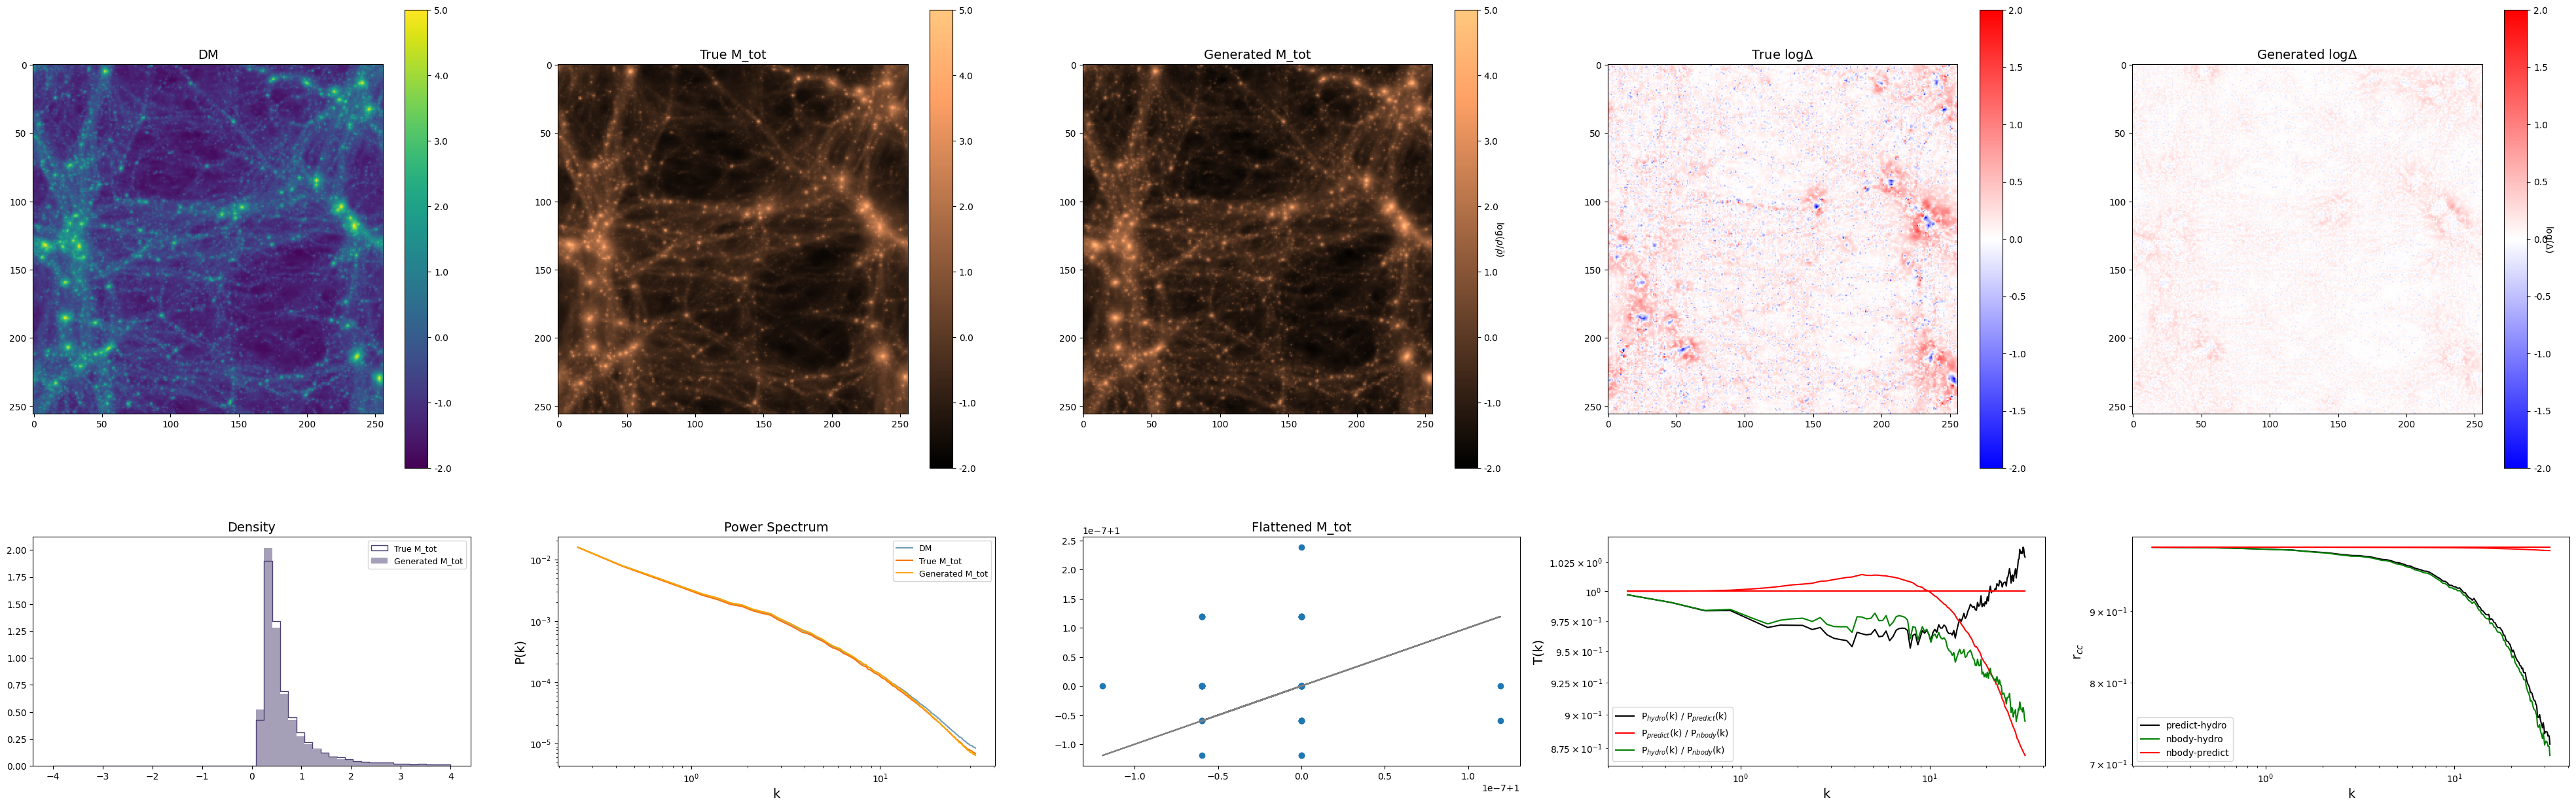

Testing DataLoader 0: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.8404651880264282     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss [2] : (0.2050062119960785, 1.8404651880264282)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64,

In [9]:
path = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt'
test_loss = trainer.test(model=cnn.to(device), datamodule=dm_TF,  ckpt_path = path)

In [10]:
trainer.validate(model=cnn, datamodule=dm_TF, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

Validation DataLoader 0: 100%|██████████| 35/35 [00:05<00:00,  6.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.18671970069408417    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics:
COMET INFO:     val_loss : 0.18671970069408417
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

[{'val_loss': 0.18671970069408417}]

In [12]:
trainer.logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_

## Conditional CNN: m_cdm -> m_tot-m_cdm (CMD 2D: 5 thickness)

In [32]:
dm = get_astro_data(
        dataset,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )

In [33]:
one_batch = next(iter(dm.test_dataloader()))

In [34]:
conditioning, params, target = one_batch
print(conditioning.shape, params.shape,target.shape)

torch.Size([50, 1, 256, 256]) torch.Size([50, 6]) torch.Size([50, 1, 256, 256])


In [54]:
conditioning, params, target = one_batch
out = UNetFiLM(1,1,use_fourier_features=False)(conditioning,params)
print(out.device,out.shape)

cpu
cpu torch.Size([50, 1, 256, 256])


In [62]:
print(MLP.to('cuda')(params.to('cuda')).device, params.device)

cuda:0 cpu


In [65]:
trainer.fit(model=cnn, datamodule=dm)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | UNetFiLM | 31.0 M | train
-------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_s

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]cuda:0
cuda:0
Epoch 0: 100%|██████████| 875/875 [02:22<00:00,  6.14it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 0: 100%|██████████| 875/875 [02:27<00:00,  5.92it/s, v_num=d543]    

Epoch 0, global step 875: 'val_loss' reached 0.06902 (best 0.06902), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=0-step=875.ckpt' as top 1


Epoch 1: 100%|██████████| 875/875 [02:24<00:00,  6.05it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 1: 100%|██████████| 875/875 [02:31<00:00,  5.76it/s, v_num=d543]    

Epoch 1, global step 1750: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 875/875 [02:23<00:00,  6.11it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 2: 100%|██████████| 875/875 [02:31<00:00,  5.79it/s, v_num=d543]    

Epoch 2, global step 2625: 'val_loss' reached 0.06846 (best 0.06846), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=2-step=2625.ckpt' as top 1


Epoch 3: 100%|██████████| 875/875 [02:25<00:00,  5.99it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 3: 100%|██████████| 875/875 [02:34<00:00,  5.66it/s, v_num=d543]    

Epoch 3, global step 3500: 'val_loss' reached 0.06662 (best 0.06662), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=3-step=3500.ckpt' as top 1


Epoch 4: 100%|██████████| 875/875 [02:24<00:00,  6.04it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 4: 100%|██████████| 875/875 [02:34<00:00,  5.68it/s, v_num=d543]    

Epoch 4, global step 4375: 'val_loss' reached 0.06516 (best 0.06516), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=4-step=4375.ckpt' as top 1


Epoch 5: 100%|██████████| 875/875 [02:25<00:00,  6.00it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 5: 100%|██████████| 875/875 [02:32<00:00,  5.74it/s, v_num=d543]    

Epoch 5, global step 5250: 'val_loss' reached 0.06435 (best 0.06435), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=5-step=5250.ckpt' as top 1


Epoch 6: 100%|██████████| 875/875 [02:22<00:00,  6.13it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 6: 100%|██████████| 875/875 [02:30<00:00,  5.80it/s, v_num=d543]    

Epoch 6, global step 6125: 'val_loss' reached 0.06137 (best 0.06137), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=6-step=6125.ckpt' as top 1


Epoch 7: 100%|██████████| 875/875 [02:24<00:00,  6.04it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 7: 100%|██████████| 875/875 [02:31<00:00,  5.78it/s, v_num=d543]    

Epoch 7, global step 7000: 'val_loss' reached 0.06104 (best 0.06104), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=7-step=7000.ckpt' as top 1


Epoch 8: 100%|██████████| 875/875 [02:24<00:00,  6.04it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 8: 100%|██████████| 875/875 [02:32<00:00,  5.75it/s, v_num=d543]    

Epoch 8, global step 7875: 'val_loss' reached 0.06037 (best 0.06037), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=8-step=7875.ckpt' as top 1


Epoch 9: 100%|██████████| 875/875 [02:24<00:00,  6.06it/s, v_num=d543]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0

Epoch 9: 100%|██████████| 875/875 [02:32<00:00,  5.73it/s, v_num=d543]    

Epoch 9, global step 8750: 'val_loss' reached 0.06001 (best 0.06001), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/best_model-epoch=9-step=8750.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 875/875 [02:33<00:00,  5.69it/s, v_num=d543]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_Film_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [10] : (2.4471741852423235e-05, 0.001)
COMET INFO:     val_loss [10] : (0.060012057423591614, 0.07051810622215271)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_Film_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNetFiLM(
  (inc): 

In [68]:
path = trainer.checkpoint_callback.best_model_path 
print(path)
path_uncond = '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt'
path_cond = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/latest-epoch=9-step=8750.ckpt'

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/latest-epoch=9-step=8750.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/latest-epoch=9-step=8750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Testing DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]cuda:0
cuda:0
cuda:0


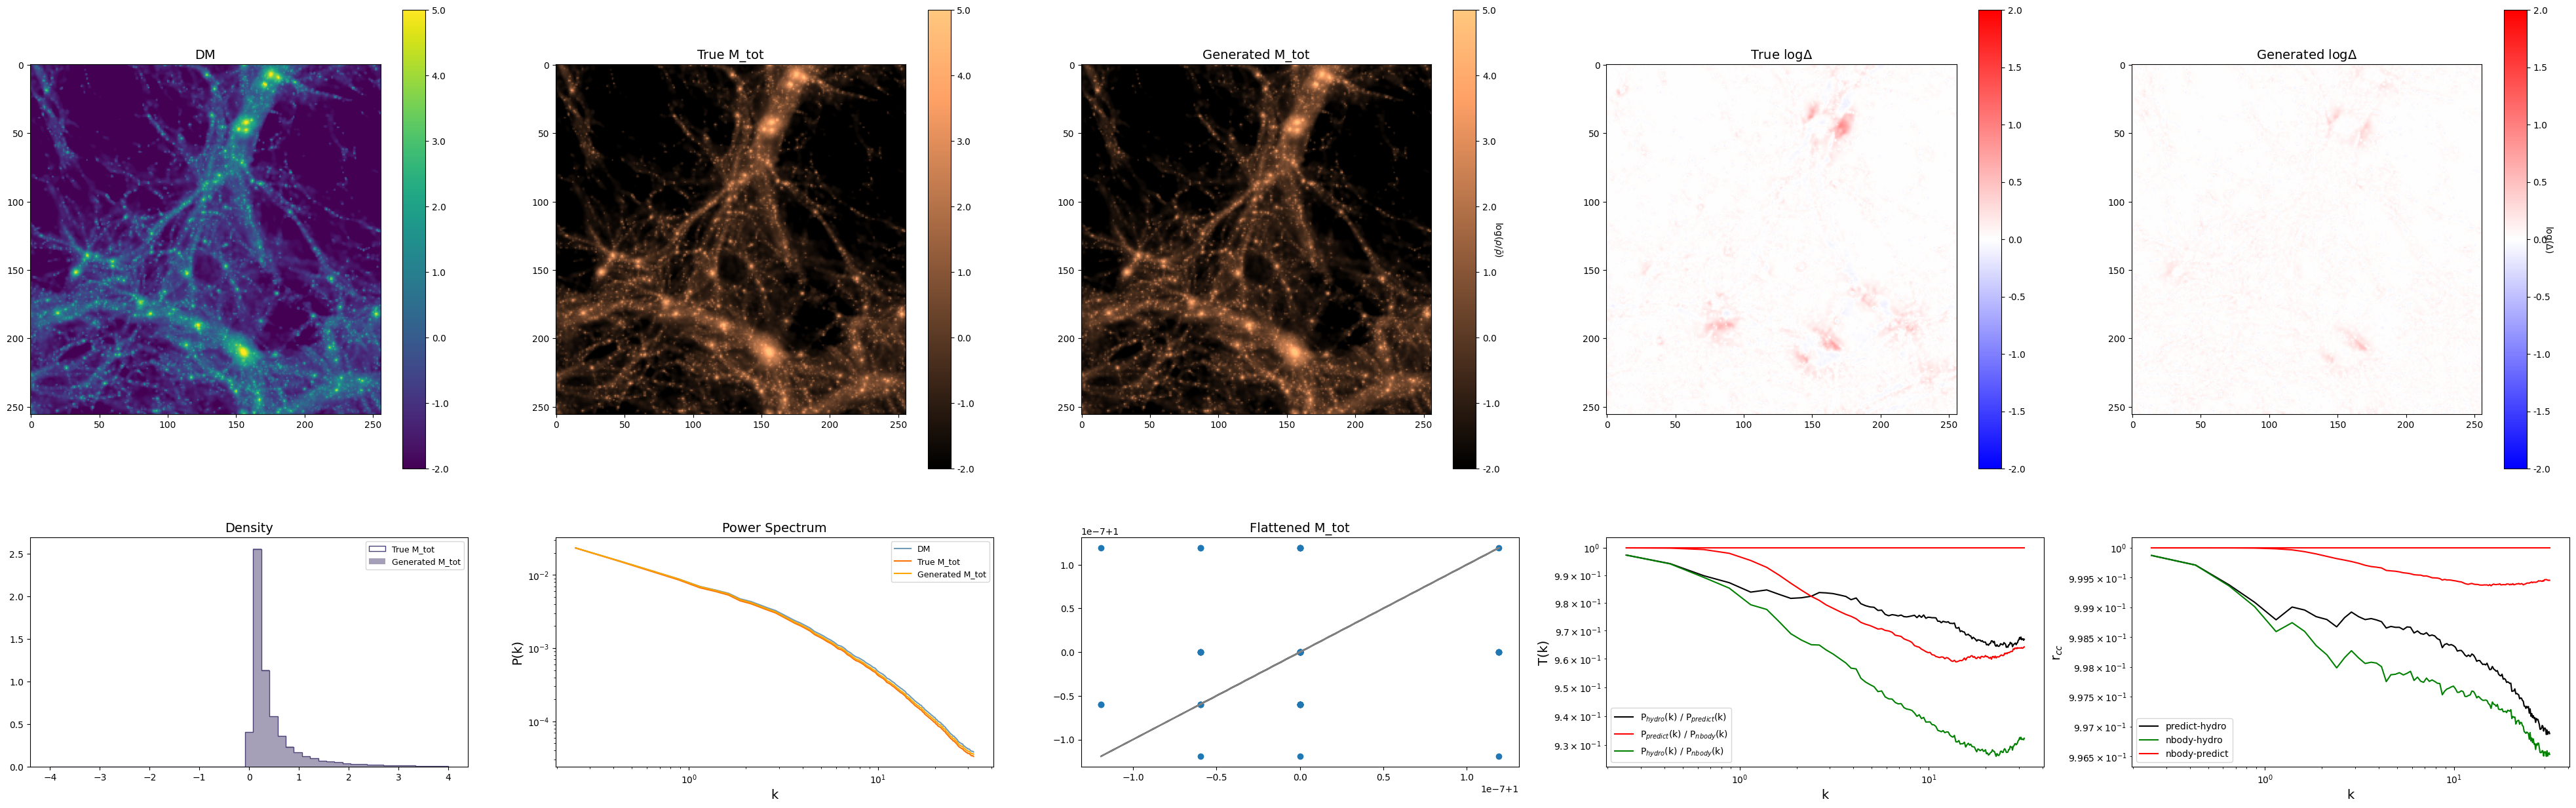

cuda:0
Testing DataLoader 0: 100%|██████████| 30/30 [00:15<00:00,  1.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.19085299968719482    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_Film_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss [2] : (0.0527200773358345, 0.19085299968719482)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_Film_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv

In [69]:
device = torch.device("cuda:2")
test_loss = trainer.test(model=cnn.to(device), datamodule=dm,  ckpt_path = path_cond)

In [70]:
trainer.validate(model=cnn, datamodule=dm, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/latest-epoch=9-step=8750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0
cuda:0
Validation DataLoader 0: 100%|██████████| 250/250 [00:14<00:00, 16.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.060045916587114334    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_Film_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/44ed9965667345bda39aaaad1cd9d543
COMET INFO:   Metrics:
COMET INFO:     val_loss : 0.060045916587114334
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_Film_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), 

[{'val_loss': 0.060045916587114334}]

In [ ]:
trainer.logger.experiment.end()

In [ ]:
ckpt= '/global/homes/l/lindajin/baryonification_cnn/baryonize_DM/eaca96d55bbd4a30ae7f56eaab6e55d8/checkpoints/latest-epoch=9-step=10000.ckpt'
state_dict=torch.load(ckpt)["state_dict"]
cnn.load_state_dict(state_dict)
cnn.eval()

'''
plot on IllustrisTNG data
'''
conditioning, x =  next(iter(dm.test_dataloader()))   #ValueError: too many values to unpack (expected 2)
with torch.no_grad():
    sample = cnn(conditioning)
fig = draw_figure(x,sample,conditioning,'Astrid')
fig.savefig(f'baryonize_DM/eaca96d55bbd4a30ae7f56eaab6e55d8/test_IllustrisTNG_1P.png')
plt.show()